In [1]:
# -*- coding: utf-8 -*-

"""
Created January 9, 2023
"""

import os
import pickle

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.misc as misc
import scipy.ndimage as ndimage
import scipy.spatial as spatial
from tqdm.notebook import tqdm


REMOTE_IMAGE_DIR = "/dartfs/rc/nosnapshots/H/HillB-scratch/OAI/processed_images/xrays/knee/BilatPAFixedFlex/224x224/no_dicom_proc/self_scaled/group_norm"


# Is there a pattern to which x-rays contain white-out and black-out sections?

Is there a pattern to which x-rays contain white-out and black-out sections?
Certain x-rays have large chunks of pure black or white at the top and bottom of them. It isn't clear if this is from the machine or some kind of PHI censoring. This could be an indicator of the source of the x-ray. A rough count makes it seem like at least 6% have this.

Examples:

- 01260803
- 00969403
- 01670901


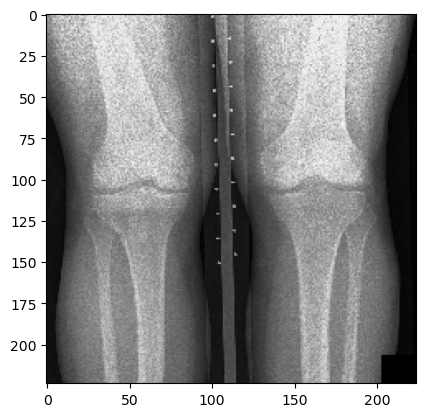

In [2]:
def view_xray(path: str) -> None:
    """View xray based on image path."""

    img_array = np.load(path)
    plt.imshow(img_array, cmap="gray")
    plt.show()


view_xray(os.path.join(REMOTE_IMAGE_DIR, "01670901.npy"))


In [3]:
class BBox(object):
    def __init__(self, x1, y1, x2, y2):
        """Bounding box wrapper class.

        (x1, y1) is the upper left corner,
        (x2, y2) is the lower right corner,
        with (0, 0) being in the upper left corner.

        """
        if x1 > x2:
            x1, x2 = x2, x1
        if y1 > y2:
            y1, y2 = y2, y1

        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2

    def taxicab_diagonal(self):
        """Return the taxicab distance from (x1,y1) to (x2,y2)."""

        return self.x2 - self.x1 + self.y2 - self.y1

    def overlaps(self, other):
        """Return True iff self and other overlap."""

        return not (
            (self.x1 > other.x2)
            or (self.x2 < other.x1)
            or (self.y1 > other.y2)
            or (self.y2 < other.y1)
        )

    def area(self):
        """Get area of bounding box."""

        xwidth = self.x2 - self.x1
        ywidth = self.y2 - self.y1

        return xwidth * ywidth

    def __str__(self):
        return str(self.x1) + str(self.x2) + str(self.y1) + str(self.y2)

    def __hash__(self):
        return hash(str(self))

    def __eq__(self, other):
        if other == None:
            return False

        return (
            self.x1 == other.x1
            and self.y1 == other.y1
            and self.x2 == other.x2
            and self.y2 == other.y2
        )


def find_boxes(data, threshold=-1):
    """Isolate boxes below threshold."""
    thresh = data < threshold

    coded_boxes, _ = ndimage.label(thresh)

    data_slices = ndimage.find_objects(coded_boxes)
    return data_slices


def slice_to_bbox(slices):
    """Convert ndimage slice object to box."""

    for s in slices:
        dy, dx = s[:2]
        yield BBox(dx.start, dy.start, dx.stop + 1, dy.stop + 1)


def largest_box(boxes):
    """Return largest bounding box below threshold."""

    largest = None

    for b in boxes:
        if not largest:
            largest = b

        if b.area() > largest.area():
            largest = b

    return largest


def largest_box_in_image(path: str, threshold=-1.15) -> int:
    """Find the largest black box in an image as percentage
    of total of area.
    """

    data = np.load(path)
    data_slices = find_boxes(data, threshold)
    bboxes = slice_to_bbox(data_slices)
    bbox = largest_box(bboxes)

    if bbox == None:
        return None

    area = bbox.area()

    return area / (data.shape[0] * data.shape[1])


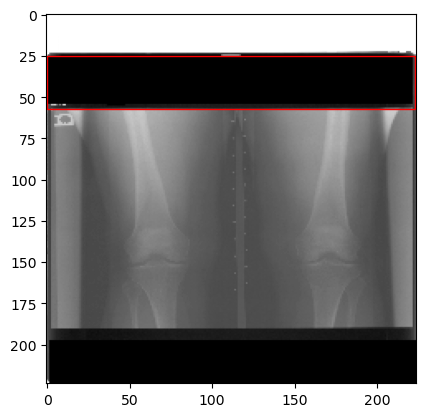

In [4]:
def view_xray_box(path: str, threshold=-1.18) -> None:
    """View xray based on image path."""

    fig = plt.figure()
    ax = fig.add_subplot(111)
    data = np.load(path)

    im = ax.imshow(data, cmap="gray")
    data_slices = find_boxes(data, threshold=threshold)

    bboxes = slice_to_bbox(data_slices)
    bbox = largest_box(bboxes)

    xwidth = bbox.x2 - bbox.x1
    ywidth = bbox.y2 - bbox.y1

    p = patches.Rectangle((bbox.x1, bbox.y1), xwidth, ywidth, fc="none", ec="red")
    ax.add_patch(p)

    plt.show()


view_xray_box(os.path.join(REMOTE_IMAGE_DIR, "00969403.npy"), threshold=-1.19)


In [6]:
image_paths = []
images = []
sizes = []

for _file in tqdm(os.listdir(REMOTE_IMAGE_DIR)):
    try:
        box_size = largest_box_in_image(
            os.path.join(REMOTE_IMAGE_DIR, _file), threshold=-1.19
        )
        image_paths.append(os.path.join(REMOTE_IMAGE_DIR, _file))
        sizes.append(box_size)
        images.append(_file.replace(".npy", ""))
    except:
        print(f"problem reading file {_file}")
        continue


  0%|          | 0/26521 [00:00<?, ?it/s]

problem reading file scale_images.py


In [28]:
df = pd.DataFrame(data={"paths": image_paths, "sizes": sizes, "image": images})

df = df.sort_values(by=["sizes"], ascending=False)

df.iloc[4100]


paths    /dartfs/rc/nosnapshots/H/HillB-scratch/OAI/pro...
sizes                                             0.103137
image                                             03408003
Name: 10643, dtype: object

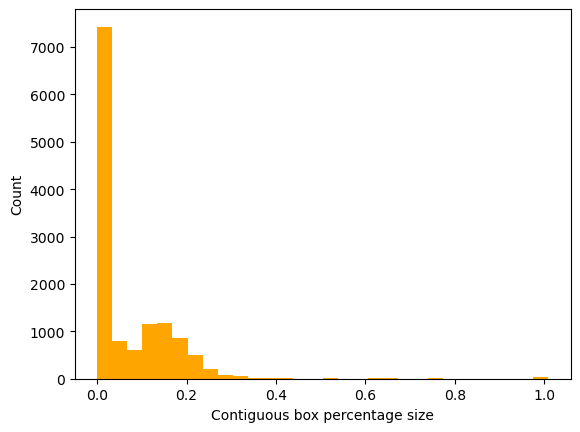

In [10]:
plt.hist(df["sizes"], bins=30, color="orange")
plt.ylabel("Count")
plt.xlabel("Contiguous box percentage size")

plt.show()


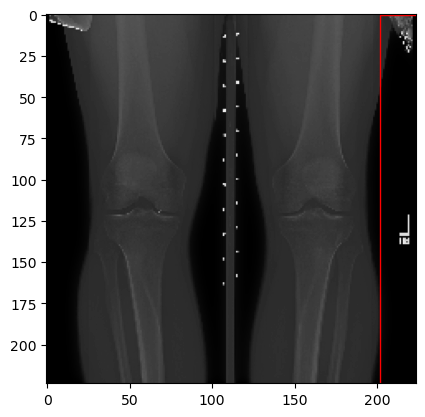

In [29]:
#view_xray_box(os.path.join(REMOTE_IMAGE_DIR, "02416001.npy"), threshold = -1.19)
view_xray_box(os.path.join(REMOTE_IMAGE_DIR, "03408003.npy"), threshold = -1.19)


## Analysis by aspect ratio

In [33]:
DICOM_METADATA_PATH = (
    "/dartfs-hpc/rc/home/f/f005gzf/projects/data/dicom_metadata_df.pkl"
)

with open(DICOM_METADATA_PATH, "rb") as f:
    dicom_df = pickle.load(f)

dicom_df


,"(0008, 0005) Specific Character Set","(0008, 0008) Image Type","(0008, 0012) Instance Creation Date","(0008, 0013) Instance Creation Time","(0008, 0016) SOP Class UID","(0008, 0018) SOP Instance UID","(0008, 0020) Study Date","(0008, 0022) Acquisition Date","(0008, 0030) Study Time","(0008, 0032) Acquisition Time",...,"(0020, 0052) Frame of Reference UID","(0040, 0250) Performed Procedure Step End Date","(0040, 0251) Performed Procedure Step End Time","(0018, 1170) Generator Power","(0018, 5020) Processing Function","(0018, 5021) Postprocessing Function","(0054, 0410) Patient Orientation Code Sequence","(0054, 0414) Patient Gantry Relationship Code Sequence","(0028, 0106) Smallest Image Pixel Value","(0028, 0107) Largest Image Pixel Value"
00700804,ISO_IR 100,"[DERIVED, PRIMARY]",20050513,091344,1.2.840.10008.5.1.4.1.1.1,1.3.6.1.4.1.21767.172.16.8.165.1158825987.343....,20050513,20050513,092624,092624,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04168501,ISO_IR 100,"[ORIGINAL, PRIMARY]",NaN,NaN,1.2.840.10008.5.1.4.1.1.1.1,1.3.6.1.4.1.21767.127.0.0.1.1377304274.0.0.1.1,20130806,20130806,142822,143521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02127103,NaN,"[DERIVED, PRIMARY, POST_PROCESSED, , , , , , 1...",NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.3.6.1.4.1.21767.172.16.8.165.1183056852.849....,20070611,20070611,112952.000,113258.531,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03558001,ISO_IR 100,NaN,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.3.6.1.4.1.21767.127.0.0.1.1284501153.0.0.1.1,20100714,20100714,132755.000000,133249,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01597503,NaN,"[ORIGINAL, SECONDARY, RADIOGRAPH]",20060726,191749,1.2.840.10008.5.1.4.1.1.1,1.3.6.1.4.1.21767.172.16.8.182.1153941474.911....,20060707,20060707,000000,000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03844601,NaN,"[DERIVED, PRIMARY, POST_PROCESSED, , , , , , 1...",NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.3.6.1.4.1.21767.127.0.0.1.1337733063.0.0.1.1,20120508,20120508,082509.406,082509.406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00507901,ISO 2022 IR 6,"[DERIVED, PRIMARY]",20050128,104756,1.2.840.10008.5.1.4.1.1.1,1.3.6.1.4.1.21767.172.16.8.165.1186833975.757....,20050128,20050128,094824,094824,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02256603,NaN,NaN,NaN,NaN,1.2.840.10008.5.1.4.1.1.7,1.3.6.1.4.1.21767.172.16.10.155.1188580343.595...,20070822,20070822,000000,000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03625601,NaN,DERIVED,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.3.6.1.4.1.21767.127.0.0.1.1300739971.0.0.1.1,20110308,20110308,091253,091432.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
